<a href="https://colab.research.google.com/github/BenWhann/ACME-Insurance-ML/blob/main/ACME_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Age vs Charges correlation: 0.2990081933306476
BMI vs Charges correlation: 0.19834096883362895
Children vs Charges correlation: 0.06799822684790478
Smoker vs Charges correlation: 0.787251430498478
               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000
Coefficient  [305.23760211]
Intercept 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



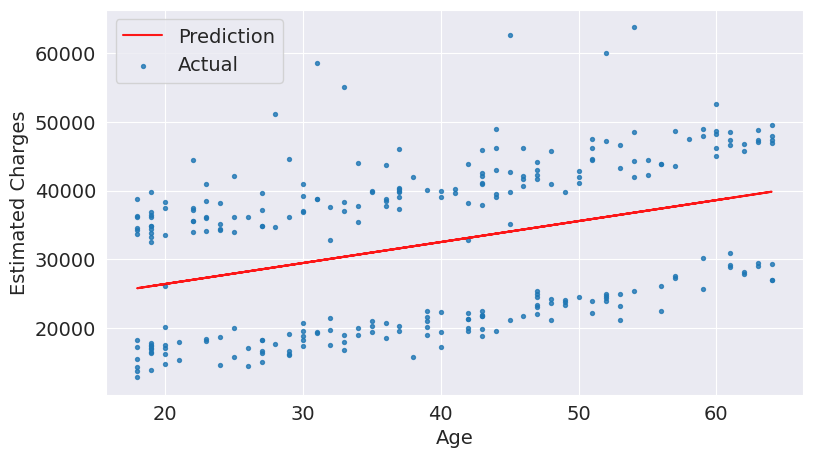

In [8]:
# Problem Statememt
# QUESTION: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, you're tasked with creating an automated system to estimate
# the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.
# Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs
# a certain prediction.
# You're given a CSV file containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers.

# My objective is to find a way to estimate the value of the charges column using values in the other columns. If I can do so with historical data, then I should be able to with new customers too,
# simply by asking for information like their age, sex, BMI, number of kids, smoking habits, and region.

medical_charges_url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'
from urllib.request import urlretrieve
urlretrieve(medical_charges_url, 'medical.csv')

!pip install numpy --quiet
!pip install pandas --quiet
!pip install plotly --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scikit-learn --quiet
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline
# %matplotlib notebook

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

medical_df = pd.read_csv('medical.csv')
medical_df.info()
medical_df.describe()

ageChargeCorr = medical_df.charges.corr(medical_df.age)
# Age vs Charges correlation

bmiChargeCorr = medical_df.charges.corr(medical_df.bmi)
# BMI vs Charges correlation

childrenChargeCorr = medical_df.charges.corr(medical_df.children)
# Children vs Charges correlation

print(f'Age vs Charges correlation: {ageChargeCorr}')
# weak positive corr
print(f'BMI vs Charges correlation: {bmiChargeCorr}')
# weak positive corr
print(f'Children vs Charges correlation: {childrenChargeCorr}')
# no correlation

# Converting categorical smoker data to numerical data
smoker_values = {'no': 0, 'yes': 1}
# provides a dictionary for the map function
smoker_numeric = medical_df.smoker.map(smoker_values)
# map function
smokerChargeCorr = medical_df.charges.corr(smoker_numeric)
# calculate correlation coefficient
print(f'Smoker vs Charges correlation: {smokerChargeCorr}')
# strong positive correlation

correlation_matrix = medical_df.corr(numeric_only=True)
print(correlation_matrix)

# sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
# plt.title('Correlation Matrix for Medical Data')

# Smoker and Age have the strongest correlations with Charges

non_smoker_df = medical_df[medical_df.smoker == 'no']
smoker_df = medical_df[medical_df.smoker == 'yes']
figAgeCharges = px.scatter(non_smoker_df, x='age', y='charges', color='smoker', opacity=0.8, hover_data=['sex'], title='Age vs Charges')
# figAgeCharges.show()

# Estimating charge value using age for non smokers

def estimate_charges(age, w, b):
  return w * age + b

w = 50
b = 100
ages = non_smoker_df.age
agesSmoker = smoker_df.age
estimated_charges = estimate_charges(ages, w, b)

# Calculating Root Mean Square Error

targets = non_smoker_df['charges']
predicted = estimate_charges(non_smoker_df.age, w, b)

# Creating optimized regression model using the fit method. The fit method calculates the best fit line using the ordinary least squares method. This is better for smaller data sets

model = LinearRegression()
inputs = smoker_df[['age']]
targets = smoker_df.charges

model.fit(inputs, targets)

predictions = model.predict(inputs)

print('Coefficient ', model.coef_)
print('Intercept ', model.intercept_)

def rmse(predictions, targets):
  return np.sqrt(np.mean(np.square(targets - predictions)))

#def tryParameters(w, b):
#  inputs = non_smoker_df[['age']]
#  target = non_smoker_df.charges
#  predictions = model.predict(inputs)
#  plt.plot(inputs, predictions, 'r', alpha=0.9)
#  plt.scatter(ages, target, s=8, alpha=0.8)
#  plt.xlabel('Age')
#  plt.ylabel('Estimated Charges')
#  plt.legend(['Prediction', 'Actual'])
#  loss = rmse(target, predictions)
#  print("RMSE Loss: ", loss)

def tryParametersSmoker(w, b):
  inputs = smoker_df[['age']]
  target = smoker_df.charges
  predictions = model.predict(inputs)
  plt.plot(inputs, predictions, 'r', alpha=0.9)
  plt.scatter(agesSmoker, target, s=8, alpha=0.8)
  plt.xlabel('Age')
  plt.ylabel('Estimated Charges')
  plt.legend(['Prediction', 'Actual'])
  loss = rmse(target, predictions)
  print("RMSE Loss: ", loss)
  print("Predicted Value: ", model.predict([[70]]))

#tryParameters(model.coef_, model.intercept_)
tryParametersSmoker(model.coef_, model.intercept_)

# Creating optimized regression model using the SGDRegressor method. The SGDRegressor method calculates the best fit line using the stochastic gradient technique. This is more efficient for larger data sets.

